## Model
Cox Prosess model with latent GP intensity function is defined as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f \sim GP(0, K_\theta)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{1:N} \sim Cox\left(\lambda(x) = \lambda_0\sigma(f(x))\right)$,

where $K_\theta(x_1,x_2) = \exp\left(\beta - \sum_{d=1,2}(x_{1d} - x_{2d})^2/\mathrm{softplus}({\alpha_d})\right)$, for $\theta=(\beta, \alpha)$.

## Import

In [3]:
# Turn GPUs off
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm, expon
from matplotlib import pyplot as plt
import time
np.random.seed(0)

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## Utilities

In [152]:
sigmoid = lambda x: 1/(1+np.exp(-x))
softplus = lambda x: np.log(1+np.exp(x))
as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

def timestamp():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d%H%M%S")  

## Data

In [100]:
def rejector(x):
    cond = tf.math.logical_and(x>=-4, x<=+4)
    cond = tf.math.logical_and(cond[:,0], cond[:,1])
    return x[cond,:]

In [110]:
def generate_data(N=10000, rejector=lambda x:x):
    K = 10
    np.random.seed(0)
    mu = np.random.randn(K*2).reshape([K,2])
    N0 = N
    while True:
        component = np.random.choice(np.arange(K), size=N)
        x = 0.2*np.random.randn(2*N).reshape([N,2]) + mu[component]
        x = rejector(x)
        if x.shape[0]>=N0:
            return x[:N0]
        else:
            N *= 2

In [126]:
N = 400
x = generate_data(N, rejector)

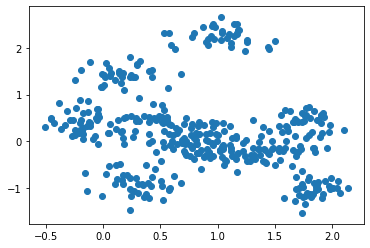

In [127]:
plt.scatter(x[:,0], x[:,1])

## MC estimator of likelihood

In [303]:
def ELBO(y, theta, phi):

    x_i = phi['x_i']
    m = phi['m']
    cholS = phi['colS']
    beta = theta['beta']
    alpha = theta['alpha']
    lambda0 = theta['lambda0']
    sp_alpha = tf.math.softplus( tf.reshape(alpha, shape=[1,1,2]) )
    x_sampler = theta['x_sampler']
    area = theta['area']
    
    N = y.shape[0]
    M = m.shape[0]
    
    def K(x1,x2):
        n1 = x1.shape[0]
        n2 = x2.shape[0]
        x1 = tf.reshape(x1, [n1, 1, 2])
        x2 = tf.reshape(x2, [1 ,n2, 2])
        return tf.exp(beta - tf.reduce_sum((x1-x2)**2 / sp_alpha, axis=2))
    
    K_ii = K(x_i, x_i)
    CholK_ii = tf.linalg.cholesky(K_ii)
    inv_CholK_ii = tf.linalg.inv(CholK_ii)
    inv_K_ii = tf.transpose(inv_CholK_ii)@inv_CholK_ii
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0, scale_tril=CholK_ii)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=cholS)
    u = q_u.sample(N)
    
    def sample_f(x_n):
        K_ni = K(x_n, x_i)
        K_in = tf.transpose(K_ni)
        f_n_mean = tf.linalg.einsum('ni,ij,nj->n', K_ni, inv_K_ii, u)
        f_n_var  = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(y, axis=1))
        f_n_var = tf.reshape(f_n_var, [N])
        f_n_var = f_n_var - tf.linalg.einsum('ni,ij,jn->n', K_ni, inv_K_ii, K_in)
        p_f_n = tfp.distributions.Normal(loc=f_n_mean, scale=f_n_var)
        f_n = p_f_n.sample()
        return f_n
    
    x_t = x_sampler(N)
    f_t = sample_f(x_t)
    f_n = sample_f(y)
    
    p_y_log_prob = tf.reduce_sum(tf.math.log(lambda0) * (tf.math.log_sigmoid(f_n)))\
                    - area * tf.reduce_mean(tf.math.log(lambda0) * (tf.math.log_sigmoid(f_t)))\
                    - tfp.distributions.kl_divergence(q_u, p_u)
    return p_y_log_prob

In [316]:
phi = {
    'x_i': tf.Variable(x_sampler(30)),
    'm': tf.Variable(np.zeros([30])),
    'colS': tf.Variable(np.eye(30, dtype=np.float64))
}
theta = {
    'beta': tf.Variable(1., dtype=tf.float64),
    'alpha': tf.Variable(np.ones([2]), dtype=tf.float64),
    'beta': tf.Variable(1., dtype=tf.float64),
    'lambda0': tf.Variable(5., dtype=tf.float64),
    'x_sampler': (lambda n: np.random.uniform(low=-4,high=4, size=n*2).reshape([n,2])),
    'area': 8*8
}

In [317]:
ELBO(x, theta, phi)

<tf.Tensor: shape=(), dtype=float64, numpy=-622.5342804546192>

In [ ]:
for i in range(100):
    phi.values()